# 7주차 실습_2

-  DSA dataset을 이용해서, 정상데이터(Lying)과 비정상데이터 설정 (다른 jumping이 아니라 activity 선택)

- Encoder와 Decoder의 구조가 같은 오토인코더로 지난주차와 동일하게 이상치 탐지

- Encoder와 Decoder의 구조가 다른 비대칭형 뉴런수로 성능 확인

- DAE를 사용하여 성능확인

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

In [2]:
df = pd.read_csv("/Users/gim-yuseong/Desktop/PycharmProjects/2024_3_2/2024_3_2_딥러닝응용/DSA_features.csv")
df

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity,people
0,7.975714,8.1605,7.6823,0.014395,0.119981,-0.023319,1.083150,1.1832,0.99744,0.002208,...,0.000792,0.177075,-0.057119,-0.054963,-0.059241,6.778722e-07,0.000823,0.036729,sitting,p1
1,7.978250,8.1763,7.8472,0.007551,0.086896,0.552416,1.140865,1.2129,1.05810,0.000784,...,0.000860,-0.286918,-0.057268,-0.054945,-0.059589,7.032302e-07,0.000839,0.347471,sitting,p1
2,7.970894,8.0860,7.8470,0.003092,0.055603,0.100538,1.140962,1.2128,1.07960,0.000508,...,0.000762,-0.134430,-0.057068,-0.054711,-0.059065,6.268222e-07,0.000792,0.045579,sitting,p1
3,7.938412,8.1083,7.6901,0.003763,0.061343,-0.231914,1.165260,1.3170,1.07870,0.002173,...,0.000735,0.021485,-0.056422,-0.053670,-0.058310,8.011245e-07,0.000895,0.240690,sitting,p1
4,7.908930,8.1305,7.8322,0.001741,0.041731,2.042285,1.187504,1.2574,1.09450,0.000662,...,0.000824,-0.148229,-0.055801,-0.053313,-0.057815,6.853423e-07,0.000828,0.258429,sitting,p1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9115,8.280854,34.1980,-2.9038,28.080803,5.299132,1.350075,-1.491537,11.2240,-11.65100,14.670334,...,0.200829,-0.040701,0.297666,0.708480,-0.117430,4.135451e-02,0.203358,-0.310022,basketBall,p8
9116,9.591118,51.6970,-3.4129,35.722025,5.976791,2.981144,0.086304,6.9951,-11.76400,5.329897,...,0.148745,-0.266377,0.224716,0.554670,-0.250950,3.355704e-02,0.183186,-0.736410,basketBall,p8
9117,9.599113,27.9300,-1.0765,48.850886,6.989341,0.449237,-0.728367,3.7801,-8.36910,5.683022,...,0.310748,-0.009505,-0.237786,0.088854,-0.477260,2.026107e-02,0.142341,0.668438,basketBall,p8
9118,9.692482,72.7820,-2.6734,59.378336,7.705734,4.491114,-0.582724,6.1216,-8.85710,4.162963,...,0.156493,0.050624,0.533023,0.677800,0.055941,1.356379e-02,0.116464,-1.482489,basketBall,p8


In [3]:
df.shape

(9120, 272)

In [4]:
df['activity'].value_counts()

activity
sitting                    480
walkingTreadmillIncline    480
jumping                    480
rowing                     480
cyclingVertical            480
cyclingHorizontal          480
crossTrainer               480
stepper                    480
runningTreadmill           480
walkingTreadmillFlat       480
standing                   480
walkingLot                 480
movingInElevator           480
standingInElevatorStill    480
decendingStairs            480
ascendingStairs            480
lyingRigh                  480
lyingBack                  480
basketBall                 480
Name: count, dtype: int64

## Non-linear AE

DSA데이터에서 lyingRigh, lyingBack(normal), sitting(abnormal)만 남기기

In [5]:
df_filtered = df[df['activity'].isin(['sitting', 'lyingRigh', 'lyingBack'])]
df_filtered = df_filtered.drop('people', axis=1)
df_filtered.head()

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity
0,7.975714,8.1605,7.6823,0.014395,0.119981,-0.023319,1.083150,1.1832,0.99744,0.002208,...,6.267229e-07,0.000792,0.177075,-0.057119,-0.054963,-0.059241,6.778722e-07,0.000823,0.036729,sitting
1,7.978250,8.1763,7.8472,0.007551,0.086896,0.552416,1.140865,1.2129,1.05810,0.000784,...,7.403458e-07,0.000860,-0.286918,-0.057268,-0.054945,-0.059589,7.032302e-07,0.000839,0.347471,sitting
2,7.970894,8.0860,7.8470,0.003092,0.055603,0.100538,1.140962,1.2128,1.07960,0.000508,...,5.802523e-07,0.000762,-0.134430,-0.057068,-0.054711,-0.059065,6.268222e-07,0.000792,0.045579,sitting
3,7.938412,8.1083,7.6901,0.003763,0.061343,-0.231914,1.165260,1.3170,1.07870,0.002173,...,5.398837e-07,0.000735,0.021485,-0.056422,-0.053670,-0.058310,8.011245e-07,0.000895,0.240690,sitting
4,7.908930,8.1305,7.8322,0.001741,0.041731,2.042285,1.187504,1.2574,1.09450,0.000662,...,6.787533e-07,0.000824,-0.148229,-0.055801,-0.053313,-0.057815,6.853423e-07,0.000828,0.258429,sitting


In [6]:
from sklearn.preprocessing import LabelEncoder

# LabelEncoder 객체 생성
label_encoder = LabelEncoder()

# 'label' 컬럼을 숫자로 변환
df_filtered['activity'] = label_encoder.fit_transform(df_filtered['activity'])

df_filtered.head()

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity
0,7.975714,8.1605,7.6823,0.014395,0.119981,-0.023319,1.083150,1.1832,0.99744,0.002208,...,6.267229e-07,0.000792,0.177075,-0.057119,-0.054963,-0.059241,6.778722e-07,0.000823,0.036729,2
1,7.978250,8.1763,7.8472,0.007551,0.086896,0.552416,1.140865,1.2129,1.05810,0.000784,...,7.403458e-07,0.000860,-0.286918,-0.057268,-0.054945,-0.059589,7.032302e-07,0.000839,0.347471,2
2,7.970894,8.0860,7.8470,0.003092,0.055603,0.100538,1.140962,1.2128,1.07960,0.000508,...,5.802523e-07,0.000762,-0.134430,-0.057068,-0.054711,-0.059065,6.268222e-07,0.000792,0.045579,2
3,7.938412,8.1083,7.6901,0.003763,0.061343,-0.231914,1.165260,1.3170,1.07870,0.002173,...,5.398837e-07,0.000735,0.021485,-0.056422,-0.053670,-0.058310,8.011245e-07,0.000895,0.240690,2
4,7.908930,8.1305,7.8322,0.001741,0.041731,2.042285,1.187504,1.2574,1.09450,0.000662,...,6.787533e-07,0.000824,-0.148229,-0.055801,-0.053313,-0.057815,6.853423e-07,0.000828,0.258429,2


In [7]:
from sklearn.preprocessing import StandardScaler

# StandardScaler 객체 생성
scaler = StandardScaler()

# 열 이름의 접두사/접미사를 사용하여 필터링
prefixes = ['T_', 'RA_', 'LA_', 'RL_', 'LL_']  # 원하는 접두사 리스
columns_to_scale = df_filtered.columns[df_filtered.columns.str.startswith(tuple(prefixes))]

# 선택한 열을 스케일링
df_filtered[columns_to_scale] = scaler.fit_transform(df_filtered[columns_to_scale])

# 스케일링 후 데이터 확인
df_filtered.head()

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity
0,1.168376,1.179659,1.134716,0.424899,1.794701,-0.037407,1.064111,1.057739,1.076760,-0.084875,...,-0.135903,-0.337940,0.344190,0.054259,0.047582,0.061705,-0.137386,-0.365251,0.185769,2
1,1.168870,1.182732,1.166896,0.154077,1.031924,0.987842,1.078602,1.065174,1.092044,-0.152909,...,-0.135459,-0.325089,-0.608202,0.053994,0.047614,0.061085,-0.137190,-0.361128,0.826319,2
2,1.167436,1.165165,1.166857,-0.022360,0.310479,0.183152,1.078626,1.065149,1.097461,-0.166074,...,-0.136085,-0.343530,-0.295205,0.054349,0.048032,0.062019,-0.137782,-0.373792,0.204012,2
3,1.161106,1.169503,1.136238,0.004198,0.442800,-0.408865,1.084727,1.091232,1.097234,-0.086558,...,-0.136242,-0.348571,0.024825,0.055501,0.049890,0.063365,-0.136432,-0.345871,0.606205,2
4,1.155360,1.173822,1.163969,-0.075787,-0.009354,3.640945,1.090312,1.076313,1.101215,-0.158700,...,-0.135700,-0.331922,-0.323528,0.056609,0.050528,0.064247,-0.137329,-0.364029,0.642770,2


In [8]:
df_filtered['activity'].value_counts()

activity
2    480
0    480
1    480
Name: count, dtype: int64

#### label

0: lyingBack (normal)

1: lyingRigh (normal)

2: sitting (abnormal)

레이블을 두개로 줄여서 해보면,

0: lyingBack, lyingRigh (normal)

1: sitting (abnormal)

In [9]:
# activity가 0 또는 1인 경우 모두 0으로 통합
df_filtered.loc[df_filtered['activity'].isin([0, 1]), 'activity'] = 0
df_filtered.loc[df_filtered['activity'].isin([2]), 'activity'] = 1

In [10]:
df_filtered['activity'].value_counts()

activity
0    960
1    480
Name: count, dtype: int64

In [11]:
LABELS = ["Normal", "Abnormal"]

In [12]:
# activity가 0 또는 1인 데이터를 선택
# normal = df_filtered[(df_filtered.activity == 0) | (df_filtered.activity == 1)]

normal = df_filtered[(df_filtered.activity == 0)]

# activity가 1인 데이터를 선택
abnormal = df_filtered[df_filtered.activity == 1]

# normal 데이터프레임의 모양 확인
normal.shape

(960, 271)

In [13]:
abnormal.shape

(480, 271)

두 activity를 섞어서 train test split

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df_filtered, test_size=0.2, random_state=20)

X_train.head()

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity
251,0.960117,0.950232,0.962964,-0.098045,-0.179856,-1.311638,0.668400,0.650195,0.685310,-0.171214,...,-0.136614,-0.361264,-0.212728,0.671552,0.665244,0.679390,-0.138551,-0.391492,0.620309,1
1014,-1.289385,-1.294578,-1.283105,-0.102654,-0.219978,-0.036127,0.626056,0.610749,0.636580,-0.148761,...,-0.136716,-0.364954,0.553317,-0.780726,-0.788678,-0.772968,-0.138579,-0.392168,0.374744,0
1123,-1.050587,-1.060132,-1.037664,-0.126880,-0.482291,0.238646,0.814733,0.806428,0.822114,-0.151350,...,-0.135879,-0.337213,0.206020,1.864770,1.858942,1.872137,-0.139361,-0.412038,-0.112684,0
255,0.961103,0.951691,0.964408,-0.093102,-0.138963,-0.458261,0.671522,0.657670,0.683377,-0.158924,...,-0.136523,-0.358030,0.138525,0.671246,0.665173,0.678712,-0.137562,-0.368999,0.154338,1
1739,-0.488581,-0.499825,-0.478488,-0.125652,-0.465710,-0.395609,-1.664104,-1.666665,-1.668773,-0.146667,...,-0.136136,-0.345153,-0.068034,-0.942195,-0.951050,-0.933048,-0.139353,-0.411825,-0.048028,0


train 데이터를 train valid split

In [15]:
X_train, X_valid = train_test_split(X_train, test_size=0.25, random_state=21)

X_valid.head()

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity
1463,0.074978,0.064277,0.080004,-0.112857,-0.317501,-0.967199,-1.129255,-1.129524,-1.126370,-0.121108,...,-0.136109,-0.344287,0.463380,-0.510145,-0.517832,-0.501701,-0.138931,-0.400835,0.654445,0
1013,-1.283197,-1.288781,-1.286032,-0.076998,-0.017845,-0.320359,0.629951,0.618021,0.632874,-0.131185,...,-0.136482,-0.356595,-0.018946,-0.777070,-0.784715,-0.770687,-0.135333,-0.325299,-0.864522,0
1343,-1.267366,-1.259015,-1.269132,-0.034206,0.246829,1.258852,1.094827,1.079567,1.104364,-0.130006,...,-0.136271,-0.349524,-0.165663,-0.058851,-0.065814,-0.051548,-0.138871,-0.399335,0.454027,0
1215,-1.141538,-1.137250,-1.142655,-0.039372,0.218006,1.087446,0.653626,0.644595,0.662755,-0.149995,...,-0.136454,-0.355631,0.149405,1.281949,1.276384,1.289283,-0.138590,-0.392434,0.677379,0
1412,-0.715663,-0.717520,-0.707839,-0.078039,-0.025210,0.215139,0.221423,0.205393,0.223036,-0.148497,...,0.026986,0.729519,0.341806,-0.980644,-0.950657,-1.014541,0.321576,1.504825,-0.240988,0


train/valid에서 sitting 데이터 삭제 (abnormal 삭제)

In [16]:
# normal feature만 가지는 X_train, X_valid
X_train = X_train[X_train.activity == 1]
X_valid = X_valid[X_valid.activity == 1]

y_train = X_train['activity']
y_valid = X_valid['activity']

X_train = X_train.drop(['activity'], axis=1)
X_valid = X_valid.drop(['activity'], axis=1)

X_train

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_min,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew
231,1.400695,1.392782,1.406912,-0.097470,-0.174988,-0.234422,0.391375,0.372933,0.411849,-0.171810,...,0.300927,-0.134187,-0.292956,0.062703,1.167044,1.162376,1.173942,-0.138788,-0.397266,0.461530
187,1.382435,1.421847,1.290915,1.006856,2.961655,-0.893772,0.408736,0.483701,0.353446,0.640332,...,0.294212,-0.123708,-0.124153,0.045976,1.170062,1.168517,1.174530,-0.106999,-0.007955,0.666230
59,1.144779,1.150594,1.129018,0.018417,0.508791,-1.122789,1.193522,1.182675,1.211923,-0.144489,...,-0.019322,-0.135738,-0.333034,-0.025054,0.060368,0.053707,0.067792,-0.136850,-0.354160,0.344105
247,0.965995,0.958928,0.971687,-0.096587,-0.167580,-0.125705,0.661572,0.646373,0.675945,-0.169391,...,0.966566,-0.136470,-0.356177,-0.721676,0.669653,0.664530,0.676609,-0.134252,-0.306552,0.751915
262,0.971767,0.961847,0.976097,-0.106393,-0.254178,-1.138540,0.682805,0.664959,0.694637,-0.161669,...,0.964702,-0.136398,-0.353751,-0.304961,0.671879,0.665833,0.679372,-0.137480,-0.367255,0.662640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,1.428997,1.428111,1.433687,-0.071047,0.023185,0.400874,0.335920,0.339540,0.344552,-0.110228,...,0.335698,-0.136002,-0.340953,0.079171,1.410951,1.404711,1.418723,-0.138868,-0.399255,0.494844
145,1.348624,1.340741,1.354475,-0.116367,-0.354605,0.959415,0.365839,0.354259,0.363197,-0.132328,...,0.769508,-0.134952,-0.311562,1.068762,1.030075,1.023498,1.037248,-0.138376,-0.387335,-0.402447
29,1.143092,1.150671,1.147830,-0.032731,0.254937,0.964676,1.123058,1.112710,1.135984,-0.147755,...,-0.023217,-0.136085,-0.343552,-0.882742,0.055381,0.050015,0.063065,-0.137268,-0.362748,0.904279
88,1.490913,1.482778,1.494320,-0.105814,-0.248770,-0.101109,0.548010,0.561266,0.535809,0.008038,...,0.625789,-0.135978,-0.340240,0.221051,1.291565,1.285453,1.297571,-0.136652,-0.350201,-0.556778


In [17]:
y_test = X_test['activity']
X_test = X_test.drop(['activity'], axis=1)

X_test

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_min,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew
1107,-1.040375,-1.047020,-1.030287,-0.118628,-0.379731,0.631063,0.810056,0.806586,0.814822,-0.129645,...,-0.286877,-0.135286,-0.320367,0.178222,1.858389,1.854068,1.865649,-0.139095,-0.405021,0.246336
1383,-0.724460,-0.735943,-0.720270,-0.106926,-0.259182,-1.318774,0.219846,0.210174,0.230997,-0.137811,...,0.040398,0.108258,0.998474,1.750317,-0.972906,-0.948497,-1.023381,0.404327,1.683691,-3.517947
1231,-1.133643,-1.129993,-1.136820,0.029895,0.559990,0.273743,0.664786,0.655096,0.681054,-0.165032,...,-0.015283,-0.135943,-0.339150,0.415904,1.288468,1.283490,1.295824,-0.137910,-0.376654,0.119500
420,1.079787,1.068418,1.088934,-0.118826,-0.381992,-0.633499,0.622834,0.612179,0.633383,-0.152408,...,-0.673074,0.162449,1.153468,-0.277774,0.989807,1.033263,0.968285,0.264218,1.371286,1.255549
321,1.221938,1.239111,1.220778,-0.013994,0.353587,0.962990,0.680268,0.675172,0.689689,-0.127037,...,0.895017,-0.136211,-0.347551,-0.032182,0.301799,0.294404,0.309987,-0.138682,-0.394669,-0.343645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1862,0.116330,0.102329,0.129748,-0.134145,-0.595048,-0.014322,-1.562432,-1.577475,-1.545744,-0.183326,...,-2.036574,0.204367,1.263969,0.849630,-0.578911,-0.543450,-0.602835,0.457267,1.791078,0.966700
244,0.954934,0.961905,0.964369,-0.104913,-0.240452,1.984792,0.660219,0.661242,0.677754,-0.139045,...,0.966877,-0.136826,-0.369113,-0.382373,0.668771,0.663548,0.676252,-0.138020,-0.379108,0.846766
280,0.978018,0.970640,0.983357,-0.088783,-0.104820,-0.427770,0.687774,0.674158,0.702022,-0.160340,...,0.964678,-0.136948,-0.373876,0.442612,0.672615,0.666547,0.680495,-0.137891,-0.376223,0.587936
1591,0.445736,0.447918,0.447473,-0.089736,-0.112235,-0.271647,-1.390316,-1.378895,-1.388753,-0.130233,...,1.189816,-0.131013,-0.229797,-0.304870,-0.790327,-0.795837,-0.785392,-0.120253,-0.128255,-0.344186


In [18]:
# X_train과 X_test를 넘파이 배열로 변환
X_train = X_train.values
X_test = X_test.values

X_train

array([[ 1.40069522,  1.39278214,  1.40691235, ..., -0.13878786,
        -0.39726613,  0.46152983],
       [ 1.38243485,  1.42184709,  1.29091471, ..., -0.10699928,
        -0.00795505,  0.66623027],
       [ 1.14477925,  1.15059366,  1.12901761, ..., -0.13685022,
        -0.35416   ,  0.34410502],
       ...,
       [ 1.14309192,  1.15067148,  1.14783015, ..., -0.13726767,
        -0.36274786,  0.90427858],
       [ 1.49091343,  1.48277843,  1.49432039, ..., -0.1366525 ,
        -0.35020088, -0.55677839],
       [ 1.37722847,  1.37313314,  1.34342979, ..., -0.09949671,
         0.05016492,  1.81075315]])

AE로 normal 정보만 가진 Train 데이터로 모델 학습 (Valid 데이터로 검증, Non-linear)

In [19]:
# 오토인코더 모델

input_dim = X_train.shape[1]
# 인코딩 차원 설정 (압축된 잠재 공간 크기)
encoding_dim = 64  # 임의로 설정한 값, 조정 가능

# 입력 레이어
input_layer = Input(shape=(input_dim,))

# 인코딩 단계 - 비선형 변환 적용
encoded = Dense(encoding_dim, activation='relu')(input_layer)
encoded = Dense(int(encoding_dim / 2), activation='relu')(encoded)
encoded = Dense(int(encoding_dim / 4), activation='relu')(encoded)

# 디코딩 단계 - 다시 원본 차원으로 복원
decoded = Dense(int(encoding_dim / 2), activation='relu')(encoded)
decoded = Dense(encoding_dim, activation='relu')(decoded)
# 마지막 출력은 원래의 입력 차원 크기로 복원하되, [0, 1] 범위로 압축된 형태로 복원하므로 sigmoid 사용
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# 오토인코더 모델 구성
autoencoder = Model(inputs=input_layer, outputs=decoded)

# 학습률을 낮추어 안정적인 학습
autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

# 모델 구조 확인
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 270)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        17,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 270)            │        17,550 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,158 (156.87 KB)

 Trainable params: 40,158 (156.87 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# 모델 학습
history = autoencoder.fit(X_train, y_train, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid, y_valid))

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.2485 - val_loss: 0.2481
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2477 - val_loss: 0.2473
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2470 - val_loss: 0.2465
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2462 - val_loss: 0.2456
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2452 - val_loss: 0.2446
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2443 - val_loss: 0.2436
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2432 - val_loss: 0.2425
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2421 - val_loss: 0.2413
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2408 - val_loss: 0.2400
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2395 - val_loss: 0.2385
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2379 - val_loss: 0.2370
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2363 - val_loss: 0.2352
Epoch 13/50

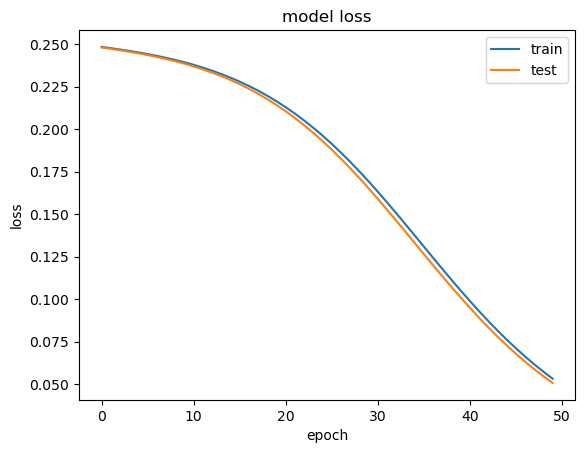

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [22]:
# X_test 값을 넣어서 Reconstruction Error 값을 얻고,
# 실제 레이블인 y_test와 데이터프레임으로 구성
# Reconstruction Error + 실제 레이블의 형태가 됨

predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


,reconstruction_error,true_class
count,288.000000,288.000000
mean,1.358699,0.340278
std,2.132999,0.474627
min,0.570105,0.000000
25%,0.852423,0.000000
50%,1.012547,0.000000
75%,1.195572,1.000000
max,24.334607,1.000000


In [23]:
error_df = error_df.reset_index(drop=True)
error_df

,reconstruction_error,true_class
0,1.230759,0
1,0.707601,0
2,0.872309,0
3,1.447410,1
4,1.134931,1
...,...,...
283,0.969610,0
284,1.283448,1
285,1.113219,1
286,0.896393,0


In [24]:
# reconstruct_error = 50%로 설정

threshold = 1.129382

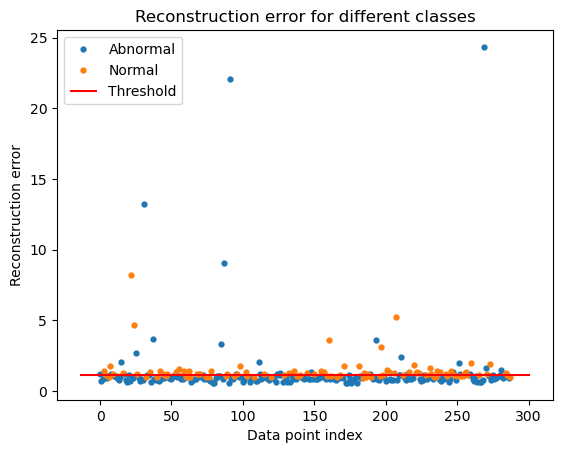

In [25]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Normal" if name == 1 else "Abnormal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

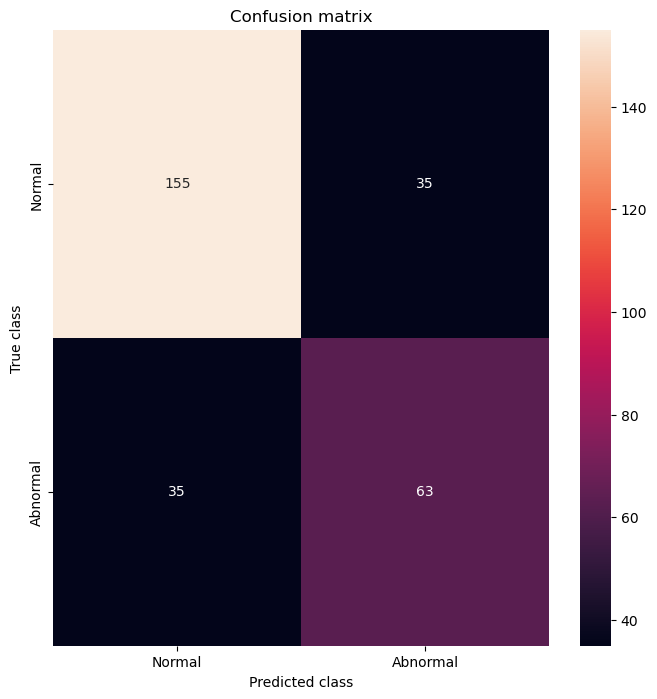

              precision    recall  f1-score   support

           0       0.82      0.82      0.82       190
           1       0.64      0.64      0.64        98

    accuracy                           0.76       288
   macro avg       0.73      0.73      0.73       288
weighted avg       0.76      0.76      0.76       288



In [26]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

print(classification_report(error_df.true_class, y_pred))